In [31]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import welch

# Jansen-Rit

In [32]:
def sigm(nu_max,v0,r,v):
  action_potential = (2*nu_max)/(1+math.exp(r*(v0-v)))
  return action_potential

In [33]:
# Parameters Eyes Closed (original param)
A = 3.25
B = 22
C = 135
C1 = 1*C
C2 = 0.8*C 
C3 = 0.25*C 
C4 = 0.25*C
v0 = 6    
a = 100 
b = 50        
nu_max = 2.5 
r = 0.56       

start = 0.0
stim_time =100
dt = 1e-4
time_array = np.arange(start=start, stop=stim_time, step=dt)
vec_len = len(time_array)
noise = np.random.uniform(120,320,vec_len)
y = np.zeros((6,vec_len))

for i in range (1,vec_len):
  y[0,i] = y[0,i-1] + y[3,i-1]*dt
  y[1,i] = y[1,i-1] + y[4,i-1]*dt
  y[2,i] = y[2,i-1] + y[5,i-1]*dt
  y[3,i] = y[3,i-1] + dt * (A*a*(sigm(nu_max,v0,r,(y[1,i-1]-y[2,i-1]))) - (2*a*y[3,i-1]) - (a**(2)*y[0,i-1]))
  y[4,i] = y[4,i-1] + dt * (A*a*(noise[i-1] + (C2*sigm(nu_max,v0,r,(C1*y[0,i-1])))) - (2*a*y[4,i-1]) - (a**(2)*y[1,i-1]))
  y[5,i] = y[5,i-1] + dt * (B*b*(C4*sigm(nu_max,v0,r,(C3*y[0,i-1]))) - (2*b*y[5,i-1]) - (b**(2)*y[2,i-1]))

output_EYES_CLOSED = y[1,:]-y[2,:]
X = signal.resample(output_EYES_CLOSED, 10000)
freqs_EC ,ps_vPN_EC = welch(X,fs=100, noverlap = 125, nperseg=1000)

In [34]:
A = 3.25
B = 22
C = 135
C1 = 1*C
C2 = 0.8*C
C3 = 0.25*C 
C4 = 0.25*C
v0 = 6         
a = 100        
b = 50        
nu_max = 2.5   
r = 0.56      

start = 0.0
stim_time =100
dt = 1e-4
time_array = np.arange(start=start, stop=stim_time, step=dt)
vec_len = len(time_array)
noise = np.random.uniform(500,200+500,vec_len)
y = np.zeros((6,vec_len))

for i in range (1,vec_len):
  y[0,i] = y[0,i-1] + y[3,i-1]*dt
  y[1,i] = y[1,i-1] + y[4,i-1]*dt
  y[2,i] = y[2,i-1] + y[5,i-1]*dt
  y[3,i] = y[3,i-1] + dt * (A*a*(sigm(nu_max,v0,r,(y[1,i-1]-y[2,i-1]))) - (2*a*y[3,i-1]) - (a**(2)*y[0,i-1]))
  y[4,i] = y[4,i-1] + dt * (A*a*(noise[i-1] + (C2*sigm(nu_max,v0,r,(C1*y[0,i-1])))) - (2*a*y[4,i-1]) - (a**(2)*y[1,i-1]))
  y[5,i] = y[5,i-1] + dt * (B*b*(C4*sigm(nu_max,v0,r,(C3*y[0,i-1]))) - (2*b*y[5,i-1]) - (b**(2)*y[2,i-1]))

output_EYES_OPEN = y[1,:]-y[2,:]
X = signal.resample(output_EYES_OPEN, 10000)
freqs_EO,ps_vPN_EO = welch(X,fs=100, noverlap = 125, nperseg=1000)

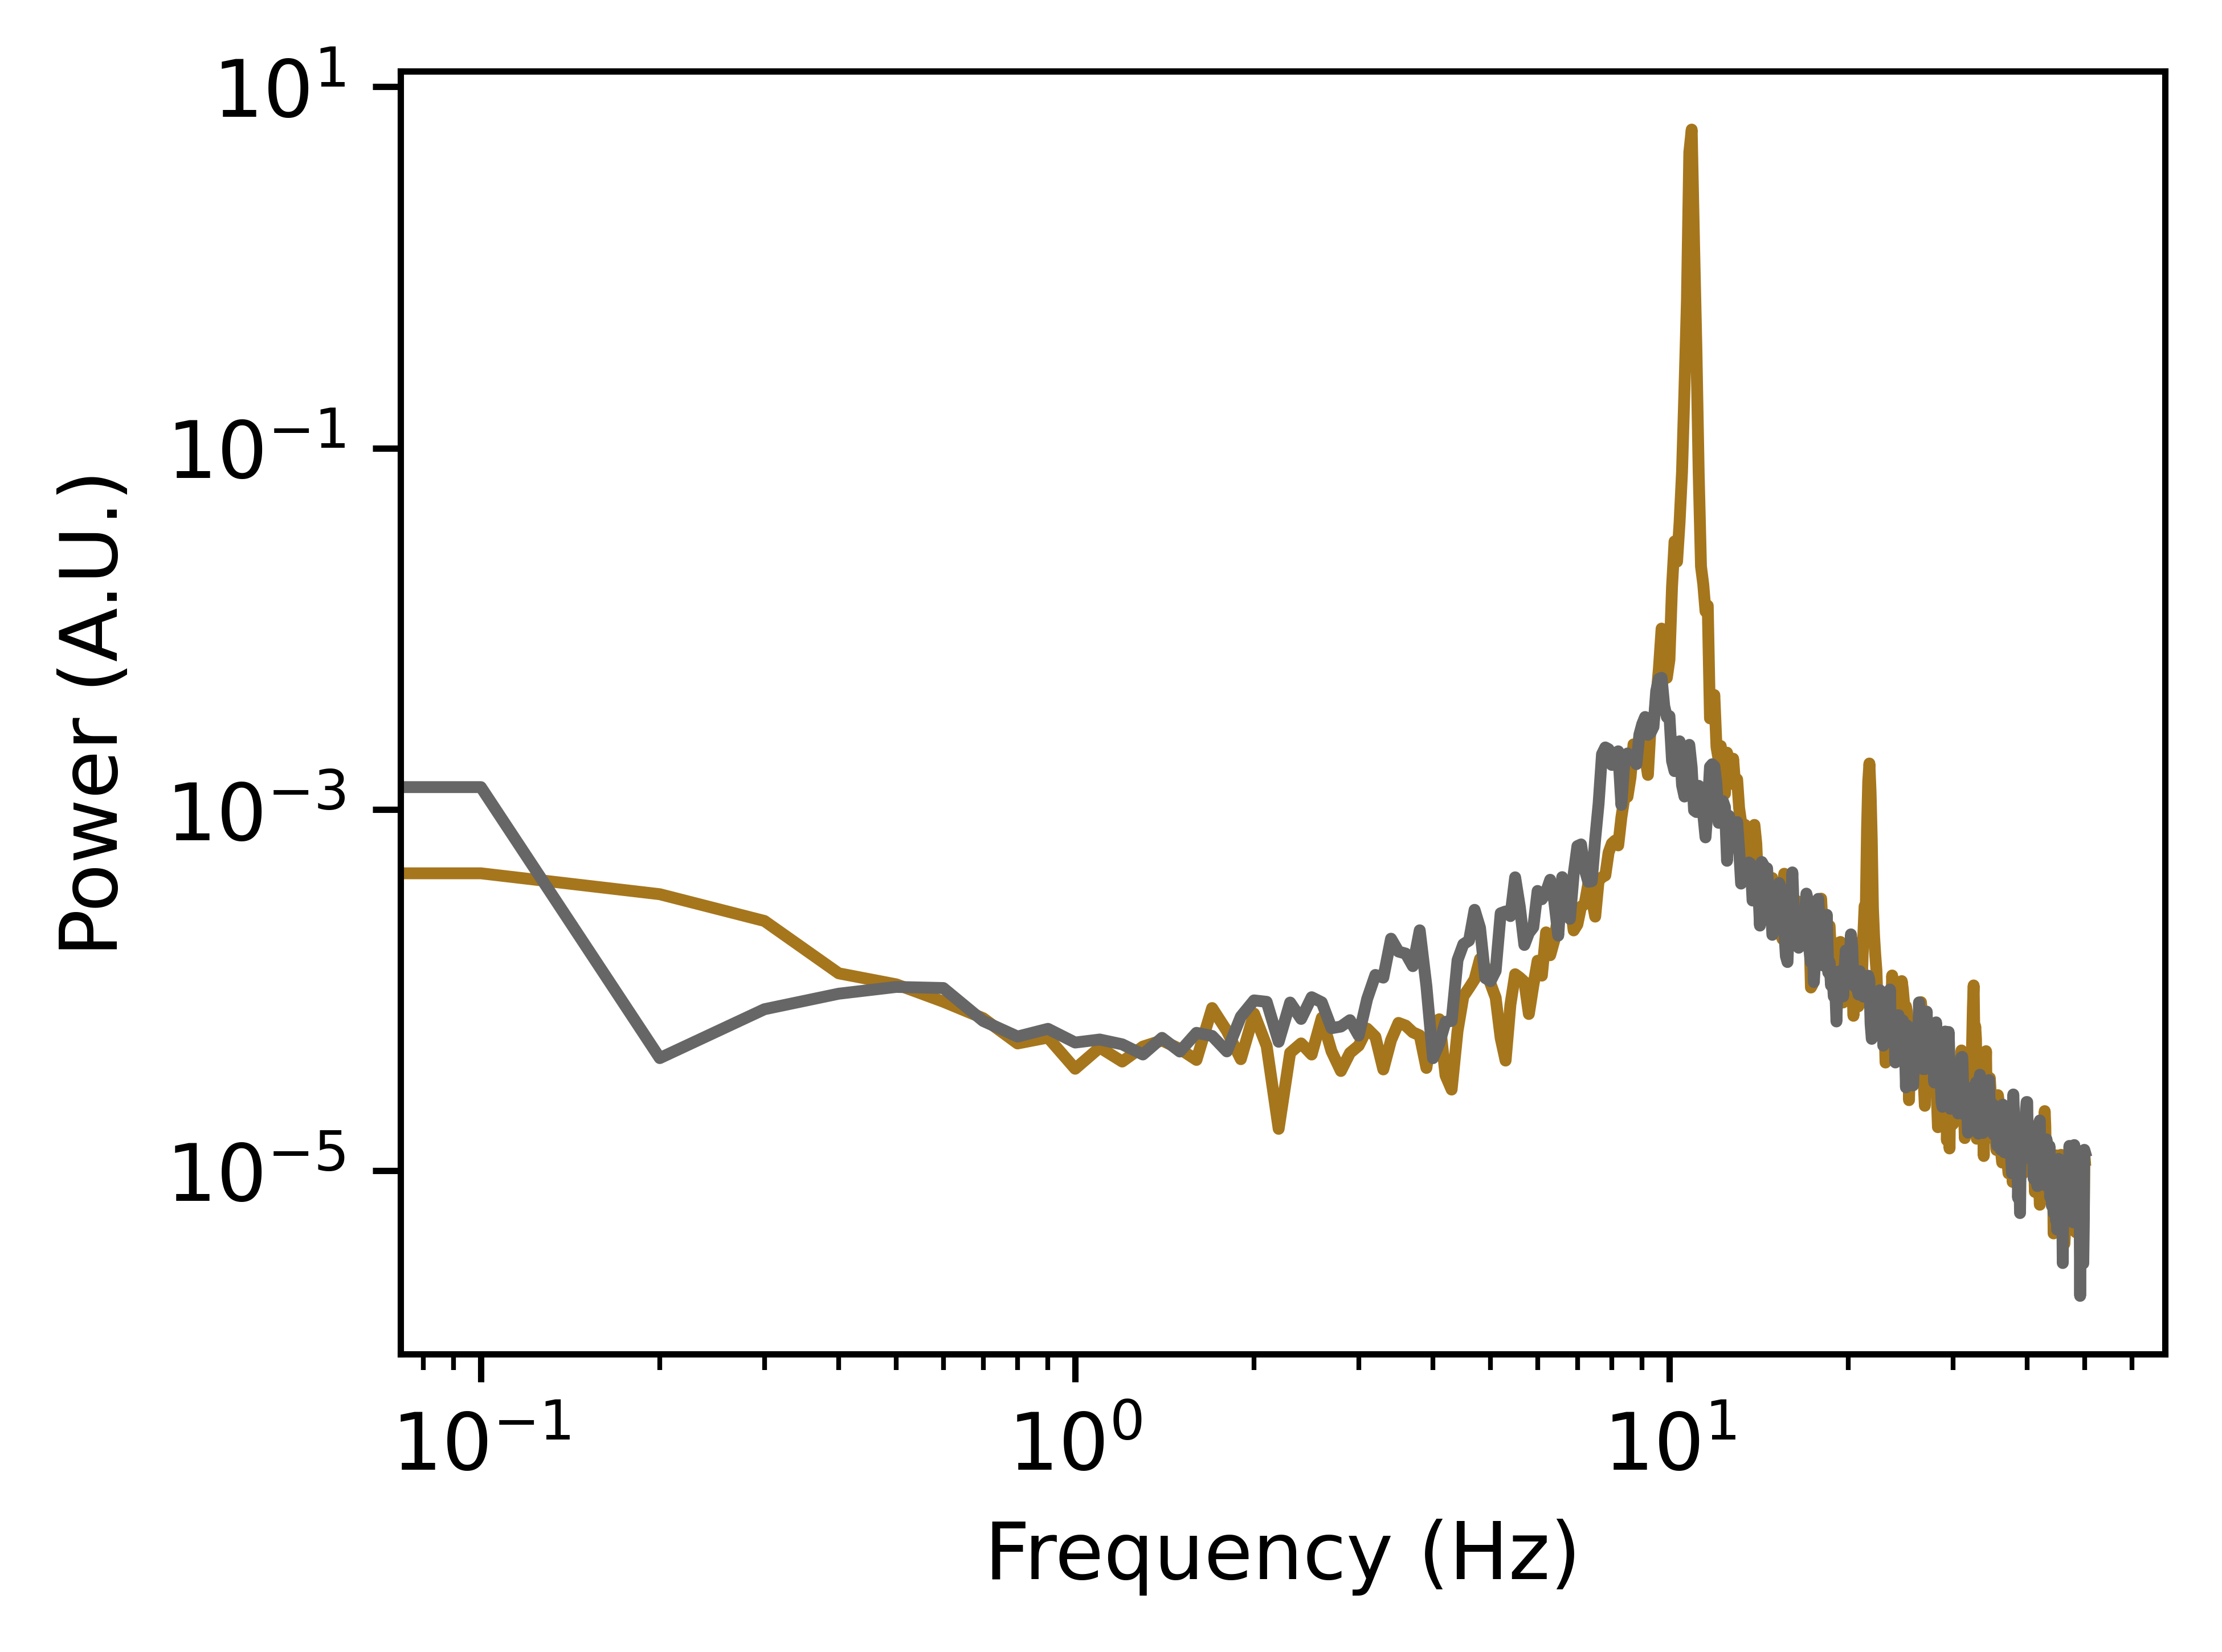

In [35]:
plt.figure(figsize=(4, 3), dpi =1000)
plt.yscale("log")
plt.xscale("log")
plt.plot(freqs_EC,ps_vPN_EC, color= plt.cm.Dark2(6))
plt.plot(freqs_EO,ps_vPN_EO,color = plt.cm.Dark2(7))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (A.U.)')
plt.tight_layout()
plt.show()

# Liley-Wright

In [36]:
def dynamics(p,X):
    dX = np.zeros((18,1))

    psi_ee=(p.h_ee_eq-X[0])/abs(p.h_ee_eq-p.h_e_r)
    psi_ie=(p.h_ie_eq-X[0])/abs(p.h_ie_eq-p.h_e_r)
    psi_ei=(p.h_ei_eq-X[1])/abs(p.h_ei_eq-p.h_i_r)
    psi_ii=(p.h_ii_eq-X[1])/abs(p.h_ii_eq-p.h_i_r)

    A_ee=p.N_ee_b*S_e(p,X[0])+X[10]+p.p_ee
    A_ei=p.N_ei_b*S_e(p,X[0])+X[12]+p.p_ei
    A_ie=p.N_ie_b*S_i(p,X[1])
    A_ii=p.N_ii_b*S_i(p,X[1])   


    dX[0] = (1/p.tau_e)*(p.h_e_r-X[0]+psi_ee*X[2]+psi_ie*X[6])
    dX[1] = (1/p.tau_i)*(p.h_i_r-X[1]+psi_ei*X[4]+psi_ii*X[8])
    dX[2] = X[3] 
    dX[3] = -2*p.gamma_ee*X[3]-p.gamma_ee**(2)*X[2]+p.gamma_ee*math.exp(1)*p.Gamma_ee*A_ee
    dX[4] = X[5] 
    dX[5] = -2*p.gamma_ei*X[5]-p.gamma_ei**(2)*X[4]+p.gamma_ei*math.exp(1)*p.Gamma_ei*A_ei
    dX[6] = X[7] 
    dX[7] = -2*p.gamma_ie*X[7]-p.gamma_ie**(2)*X[6]+p.gamma_ie*math.exp(1)*p.Gamma_ie*A_ie
    dX[8] = X[9] 
    dX[9] = -2*p.gamma_ii*X[9]-p.gamma_ii**(2)*X[8]+p.gamma_ii*math.exp(1)*p.Gamma_ii*A_ii
    return dX
    
def S_e(t,v):   
    p = t
    spikerate = p.S_e_max/(1 + math.exp(-math.sqrt(2)*(v - p.mu_e)/p.sigma_e))
    return spikerate

def S_i(t,v):
    p=t
    spikerate = p.S_i_max/(1 + math.exp(-math.sqrt(2)*(v - p.mu_i)/p.sigma_i))
    return spikerate

In [37]:
# Parameters for eyes-open with changes in p_ei
class p:
  S_e_max = 0.5
  S_i_max = 0.5
  h_e_r = -70
  h_i_r = -70
  mu_e = -50
  mu_i = -50
  sigma_e = 5
  sigma_i = 5
  tau_e = 94
  tau_i = 42
  h_ee_eq = 4
  h_ei_eq = 45
  h_ie_eq = -90
  h_ii_eq = -90
  Gamma_ee = 0.71
  Gamma_ei = 0.71
  Gamma_ie = 0.71
  Gamma_ii = 0.71
  gamma_ee = 0.3
  gamma_ei = 0.3
  gamma_ie = 0.065
  gamma_ii = 0.065
  p_ee = 3.460
  p_ee_sd = 1.000
  p_ei = 6 
  p_ei_sd = 0
  p_ie = 0
  p_ii = 0
  N_ei_b = 3000
  N_ee_b = 3000
  N_ie_b = 500
  N_ii_b = 500

In [38]:
sim_time= 100           
dt = 1e-4
steps=  1/dt         
white_noise=1        

p.v_e_equil = p.h_e_r
p.v_i_equil = p.h_i_r
h = 1000/steps 
T = sim_time*10**3 
N = T/h-1

X = np.zeros((18,int(N)))
X[0,0] = p.v_e_equil
X[1,0] = p.v_i_equil    
X[2,0] = math.exp(1)/p.gamma_ee*p.Gamma_ee*(p.N_ee_b*S_e(p,p.v_e_equil) + 0*S_e(p,p.v_e_equil)+p.p_ee)    
X[4,0] = math.exp(1)/p.gamma_ei*p.Gamma_ei*(p.N_ei_b*S_e(p,p.v_e_equil) + 0*S_e(p,p.v_e_equil)+p.p_ei)
X[6,0] = math.exp(1)/p.gamma_ie*p.Gamma_ie*(p.N_ie_b*S_i(p,p.v_i_equil))
X[8,0] = math.exp(1)/p.gamma_ii*p.Gamma_ii*(p.N_ii_b*S_i(p,p.v_i_equil))
 
for n in range (0,int(N-1)):
    noise = np.zeros((18,1))
    if (white_noise==1):
      noise[3]= p.gamma_ee*math.exp(p.gamma_ee/p.gamma_ee)*p.Gamma_ee*p.p_ee_sd*np.random.randn(1,1)
    X[:,n+1] = X[:,n] + ((h*dynamics(p,X[:,n])+math.sqrt(h)*noise).flatten())
EEG=-X[0,:]

new_EEG =signal.resample(EEG,10000)
freqs_OPEN,ps_vPN_OPEN = welch(new_EEG,fs=100, noverlap = 125, nperseg=1000)

In [39]:
# Parameters for eyes-closed (original values)
class p:
  S_e_max = 0.5
  S_i_max = 0.5
  h_e_r = -70
  h_i_r = -70
  mu_e = -50
  mu_i = -50
  sigma_e = 5
  sigma_i = 5
  tau_e = 94
  tau_i = 42
  h_ee_eq = 4
  h_ei_eq = 45
  h_ie_eq = -90
  h_ii_eq = -90
  Gamma_ee = 0.71
  Gamma_ei = 0.71
  Gamma_ie = 0.71
  Gamma_ii = 0.71
  gamma_ee = 0.3
  gamma_ei = 0.3
  gamma_ie = 0.065
  gamma_ii = 0.065
  p_ee = 3.460
  p_ee_sd = 1.000
  p_ei = 5.070
  p_ei_sd = 0
  p_ie = 0
  p_ii = 0
  N_ei_b = 3000
  N_ee_b = 3000
  N_ie_b = 500
  N_ii_b = 500

In [40]:
sim_time= 100          
dt = 1e-4
steps=  1/dt            
white_noise=1         

p.v_e_equil = p.h_e_r
p.v_i_equil = p.h_i_r
h = 1000/steps 
T = sim_time*10**3 
N = T/h-1

X = np.zeros((18,int(N)))
X[0,0] = p.v_e_equil  
X[1,0] = p.v_i_equil    
X[2,0] = math.exp(1)/p.gamma_ee*p.Gamma_ee*(p.N_ee_b*S_e(p,p.v_e_equil) + 0*S_e(p,p.v_e_equil)+p.p_ee)   
X[4,0] = math.exp(1)/p.gamma_ei*p.Gamma_ei*(p.N_ei_b*S_e(p,p.v_e_equil) + 0*S_e(p,p.v_e_equil)+p.p_ei)
X[6,0] = math.exp(1)/p.gamma_ie*p.Gamma_ie*(p.N_ie_b*S_i(p,p.v_i_equil))#
X[8,0] = math.exp(1)/p.gamma_ii*p.Gamma_ii*(p.N_ii_b*S_i(p,p.v_i_equil))#
 
for n in range (0,int(N-1)):
    noise = np.zeros((18,1))
    if (white_noise==1):
      noise[3]= p.gamma_ee*math.exp(p.gamma_ee/p.gamma_ee)*p.Gamma_ee*p.p_ee_sd*np.random.randn(1,1)
    X[:,n+1] = X[:,n] + ((h*dynamics(p,X[:,n])+math.sqrt(h)*noise).flatten())
EEG=-X[0,:]

new_EEG =signal.resample(EEG,10000)
freqs_CLOSED,ps_vPN_CLOSED = welch(new_EEG,fs=100, noverlap = 125, nperseg=1000)

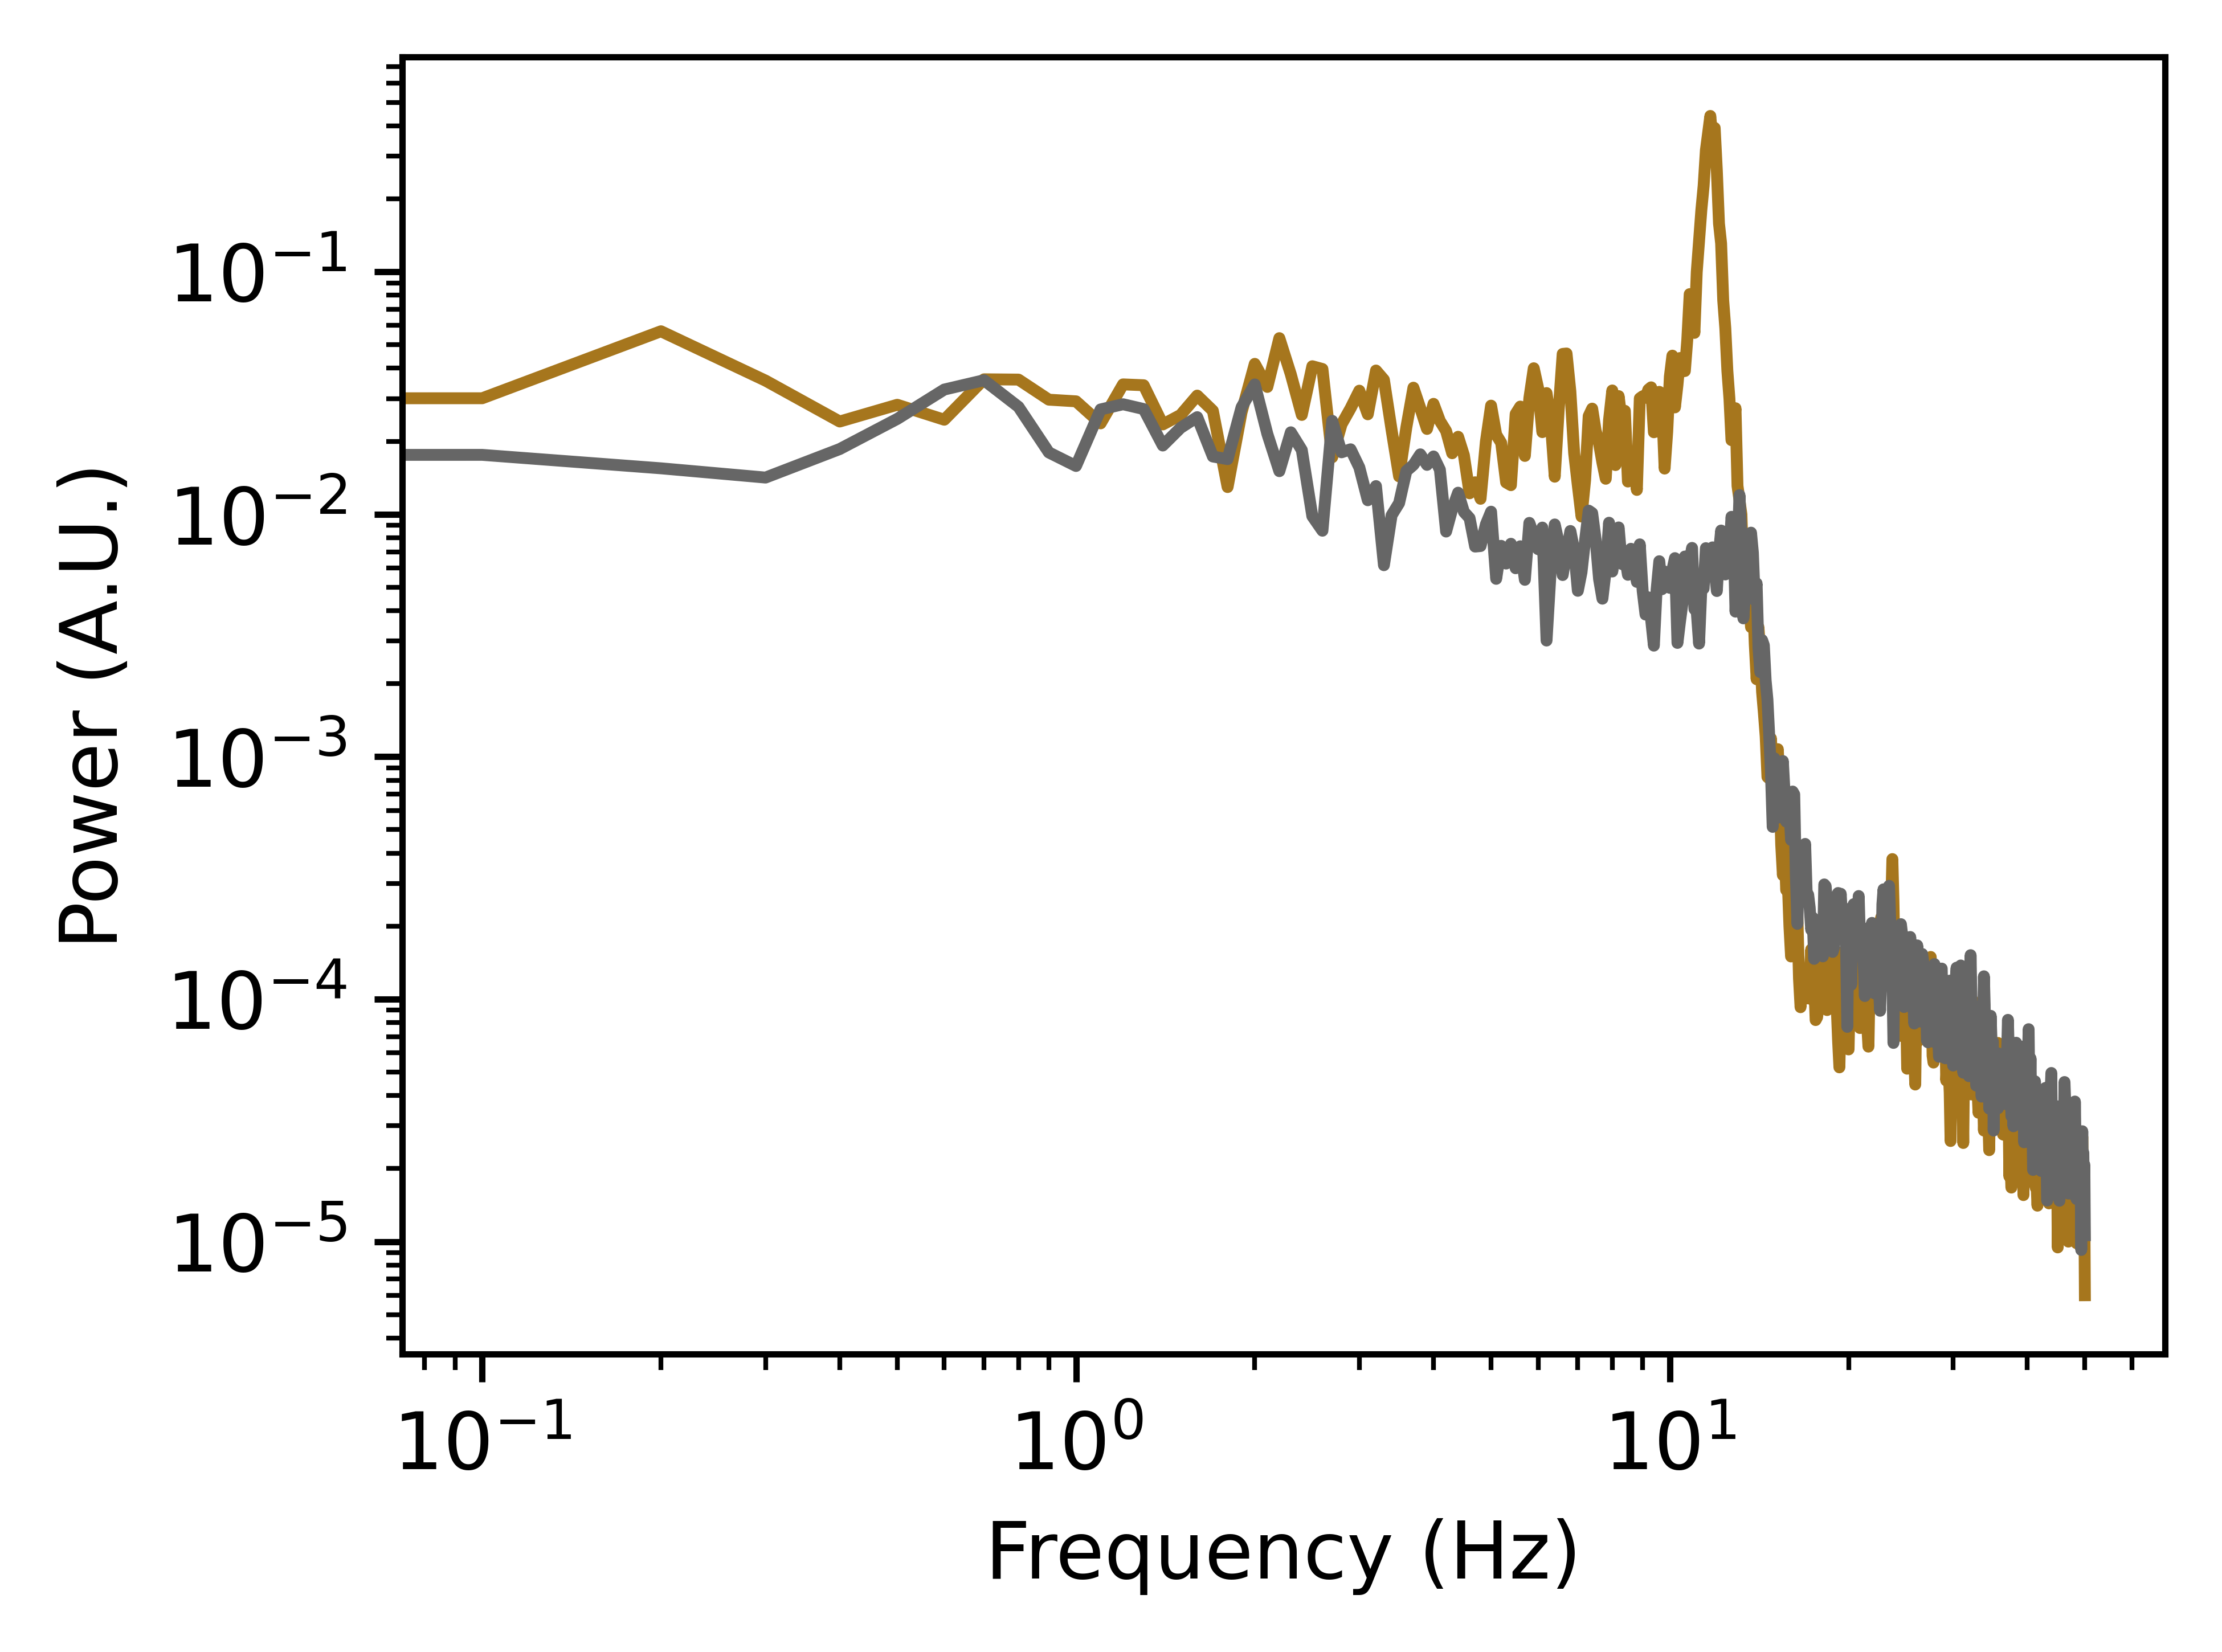

In [41]:
plt.figure(figsize=(4, 3), dpi =1000)
plt.yscale("log")
plt.xscale("log")
plt.plot(freqs_CLOSED,ps_vPN_CLOSED, color= plt.cm.Dark2(6))
plt.plot(freqs_OPEN,ps_vPN_OPEN,color = plt.cm.Dark2(7))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (A.U.)')
plt.tight_layout()
plt.show()

# Robinson-Rennie-Wright

In [42]:
def sig(v,Qmax,theta,sigma):
 firing_rate = Qmax / (1 + math.exp(-(v-theta) / sigma))
 return firing_rate

In [43]:
# Parameters from Abeysuriya 2015 Eyes Closed
gamma = 116 
t0 = 85e-3 
Qmax = 340 
theta = 12.9e-3 
sigma = 3.8e-3 
phin_0 = 1.0 

nu_ee = 1.53e-3 
nu_ei = -3.02e-3 
nu_es = 0.57e-3 
nu_se = 3.45e-3
nu_sr = -1.47e-3 
nu_sn = 3.59e-3 
nu_re = 0.17e-3 
nu_rs = 0.05e-3
nu_ie = 1.53e-3 
nu_ii = -3.02e-3 
nu_is = 0.57e-3
alpha = 83 
beta = 769 
phin = 5e-4

start = 0.0
stop = 100.0 + t0/2
dt = 1e-4
k0 = int(t0/2/dt) 
time_array = np.arange(start=start, stop=stop, step=dt)
vec_len = len(time_array)

np.random.seed(0)
noise = alpha*beta*nu_sn*math.sqrt(phin*dt)*np.random.randn(vec_len,1)

# Outputs
phie = np.zeros(vec_len)
Ve = np.zeros(vec_len)
Vr = np.zeros(vec_len)
Vs = np.zeros(vec_len)
phiedot = np.zeros(vec_len)
Vedot = np.zeros(vec_len)
Vrdot = np.zeros(vec_len)
Vsdot = np.zeros(vec_len)

# Initialize output
phie[0:(k0+1)] = 3.175
Ve[0:(k0+1)]  = 0.0006344; 
Vr[0:(k0+1)]  = 0.005676;
Vs[0:(k0+1)]  = -0.003234;

for i in range ((k0+1),(int(stop/dt))):
    Ve[i] = Ve[i-1] + Vedot[i-1]*dt
    Vedot[i] = Vedot[i-1] + dt *( alpha*beta * ( nu_ee*phie[i-1] + nu_ei*sig(Ve[i-1],Qmax,theta,sigma) + nu_es*sig(Vs[i-1-k0],Qmax,theta,sigma) - (1/alpha + 1/beta)*Vedot[i-1] - Ve[i-1] ) )
      
    Vr[i] = Vr[i-1] + Vrdot[i-1]*dt
    Vrdot[i] = Vrdot[i-1] + dt*( alpha*beta * ( nu_re*phie[i-1-k0] + nu_rs*sig(Vs[i-1],Qmax,theta,sigma) - (1/alpha + 1/beta)*Vrdot[i-1] - Vr[i-1] ))
    
    Vs[i] = Vs[i-1] + Vsdot[i-1]*dt
    Vsdot[i] = Vsdot[i-1] + dt*( alpha*beta * ( nu_se*phie[i-1-k0] + nu_sr*sigr(Vr[i-1],Qmax,theta,sigma_r) - (1/alpha + 1/beta)*Vsdot[i-1] - Vs[i-1] + nu_sn*phin_0 )) + noise[i-1]
    
    phie[i] = phie[i-1] + phiedot[i-1]*dt
    phiedot[i] = phiedot[i-1] + dt*( gamma**(2) * ( sig(Ve[i-1],Qmax,theta,sigma) - 2/gamma*phiedot[i-1] - phie[i-1] ))

phie = phie[(k0+1):len(phie)]
Ve = Ve[(k0+1):len(Ve)]
Vr = Vr[(k0+1):len(Vr)]
Vs = Vs[(k0+1):len(Vs)];

time_array = time_array[(k0+1):len(time_array)];
phie_EYES_CLOSED = phie

In [44]:
# Parameters from Abeysuriya 2015 Eyes Open
gamma = 116
t0 = 85e-3 
Qmax = 340 
theta = 12.9e-3 
sigma = 3.8e-3 
phin_0 = 1.0 

nu_ee = 7.85e-3 
nu_ei = -9.88e-3 
nu_es = 0.90e-3 
nu_se = 2.68e-3 
nu_sr = -1.31e-3 
nu_sn = 6.60e-3 
nu_re = 0.21e-3 
nu_rs = 0.06e-3
nu_ie = 7.85e-3 
nu_ii = -9.88e-3 
nu_is = 0.90e-3 
alpha = 83 
beta = 769 
phin = 5e-4

start = 0.0
stop = 100.0 + t0/2
dt = 1e-4
k0 = int(t0/2/dt) 
time_array = np.arange(start=start, stop=stop, step=dt)
vec_len = len(time_array)

np.random.seed(0)
noise = alpha*beta*nu_sn*math.sqrt(phin*dt)*np.random.randn(vec_len,1)

# Outputs
phie = np.zeros(vec_len)
Ve = np.zeros(vec_len)
Vr = np.zeros(vec_len)
Vs = np.zeros(vec_len)
phiedot = np.zeros(vec_len)
Vedot = np.zeros(vec_len)
Vrdot = np.zeros(vec_len)
Vsdot = np.zeros(vec_len)

# Initialize output
phie[0:(k0+1)] = 3.175
Ve[0:(k0+1)]  = 0.0006344; 
Vr[0:(k0+1)]  = 0.005676;
Vs[0:(k0+1)]  = -0.003234;

for i in range ((k0+1),(int(stop/dt))):
    Ve[i] = Ve[i-1] + Vedot[i-1]*dt
    Vedot[i] = Vedot[i-1] + dt *( alpha*beta * ( nu_ee*phie[i-1] + nu_ei*sig(Ve[i-1],Qmax,theta,sigma) + nu_es*sig(Vs[i-1-k0],Qmax,theta,sigma) - (1/alpha + 1/beta)*Vedot[i-1] - Ve[i-1] ) )
      
    Vr[i] = Vr[i-1] + Vrdot[i-1]*dt
    Vrdot[i] = Vrdot[i-1] + dt*( alpha*beta * ( nu_re*phie[i-1-k0] + nu_rs*sig(Vs[i-1],Qmax,theta,sigma) - (1/alpha + 1/beta)*Vrdot[i-1] - Vr[i-1] ))
    
    Vs[i] = Vs[i-1] + Vsdot[i-1]*dt
    Vsdot[i] = Vsdot[i-1] + dt*( alpha*beta * ( nu_se*phie[i-1-k0] + nu_sr*sigr(Vr[i-1],Qmax,theta,sigma_r) - (1/alpha + 1/beta)*Vsdot[i-1] - Vs[i-1] + nu_sn*phin_0 )) + noise[i-1]
    
    phie[i] = phie[i-1] + phiedot[i-1]*dt
    phiedot[i] = phiedot[i-1] + dt*( gamma**(2) * ( sig(Ve[i-1],Qmax,theta,sigma) - 2/gamma*phiedot[i-1] - phie[i-1] ))


phie = phie[(k0+1):len(phie)]
Ve = Ve[(k0+1):len(Ve)]
Vr = Vr[(k0+1):len(Vr)]
Vs = Vs[(k0+1):len(Vs)];

time_array = time_array[(k0+1):len(time_array)];
phie_EYES_OPEN = phie

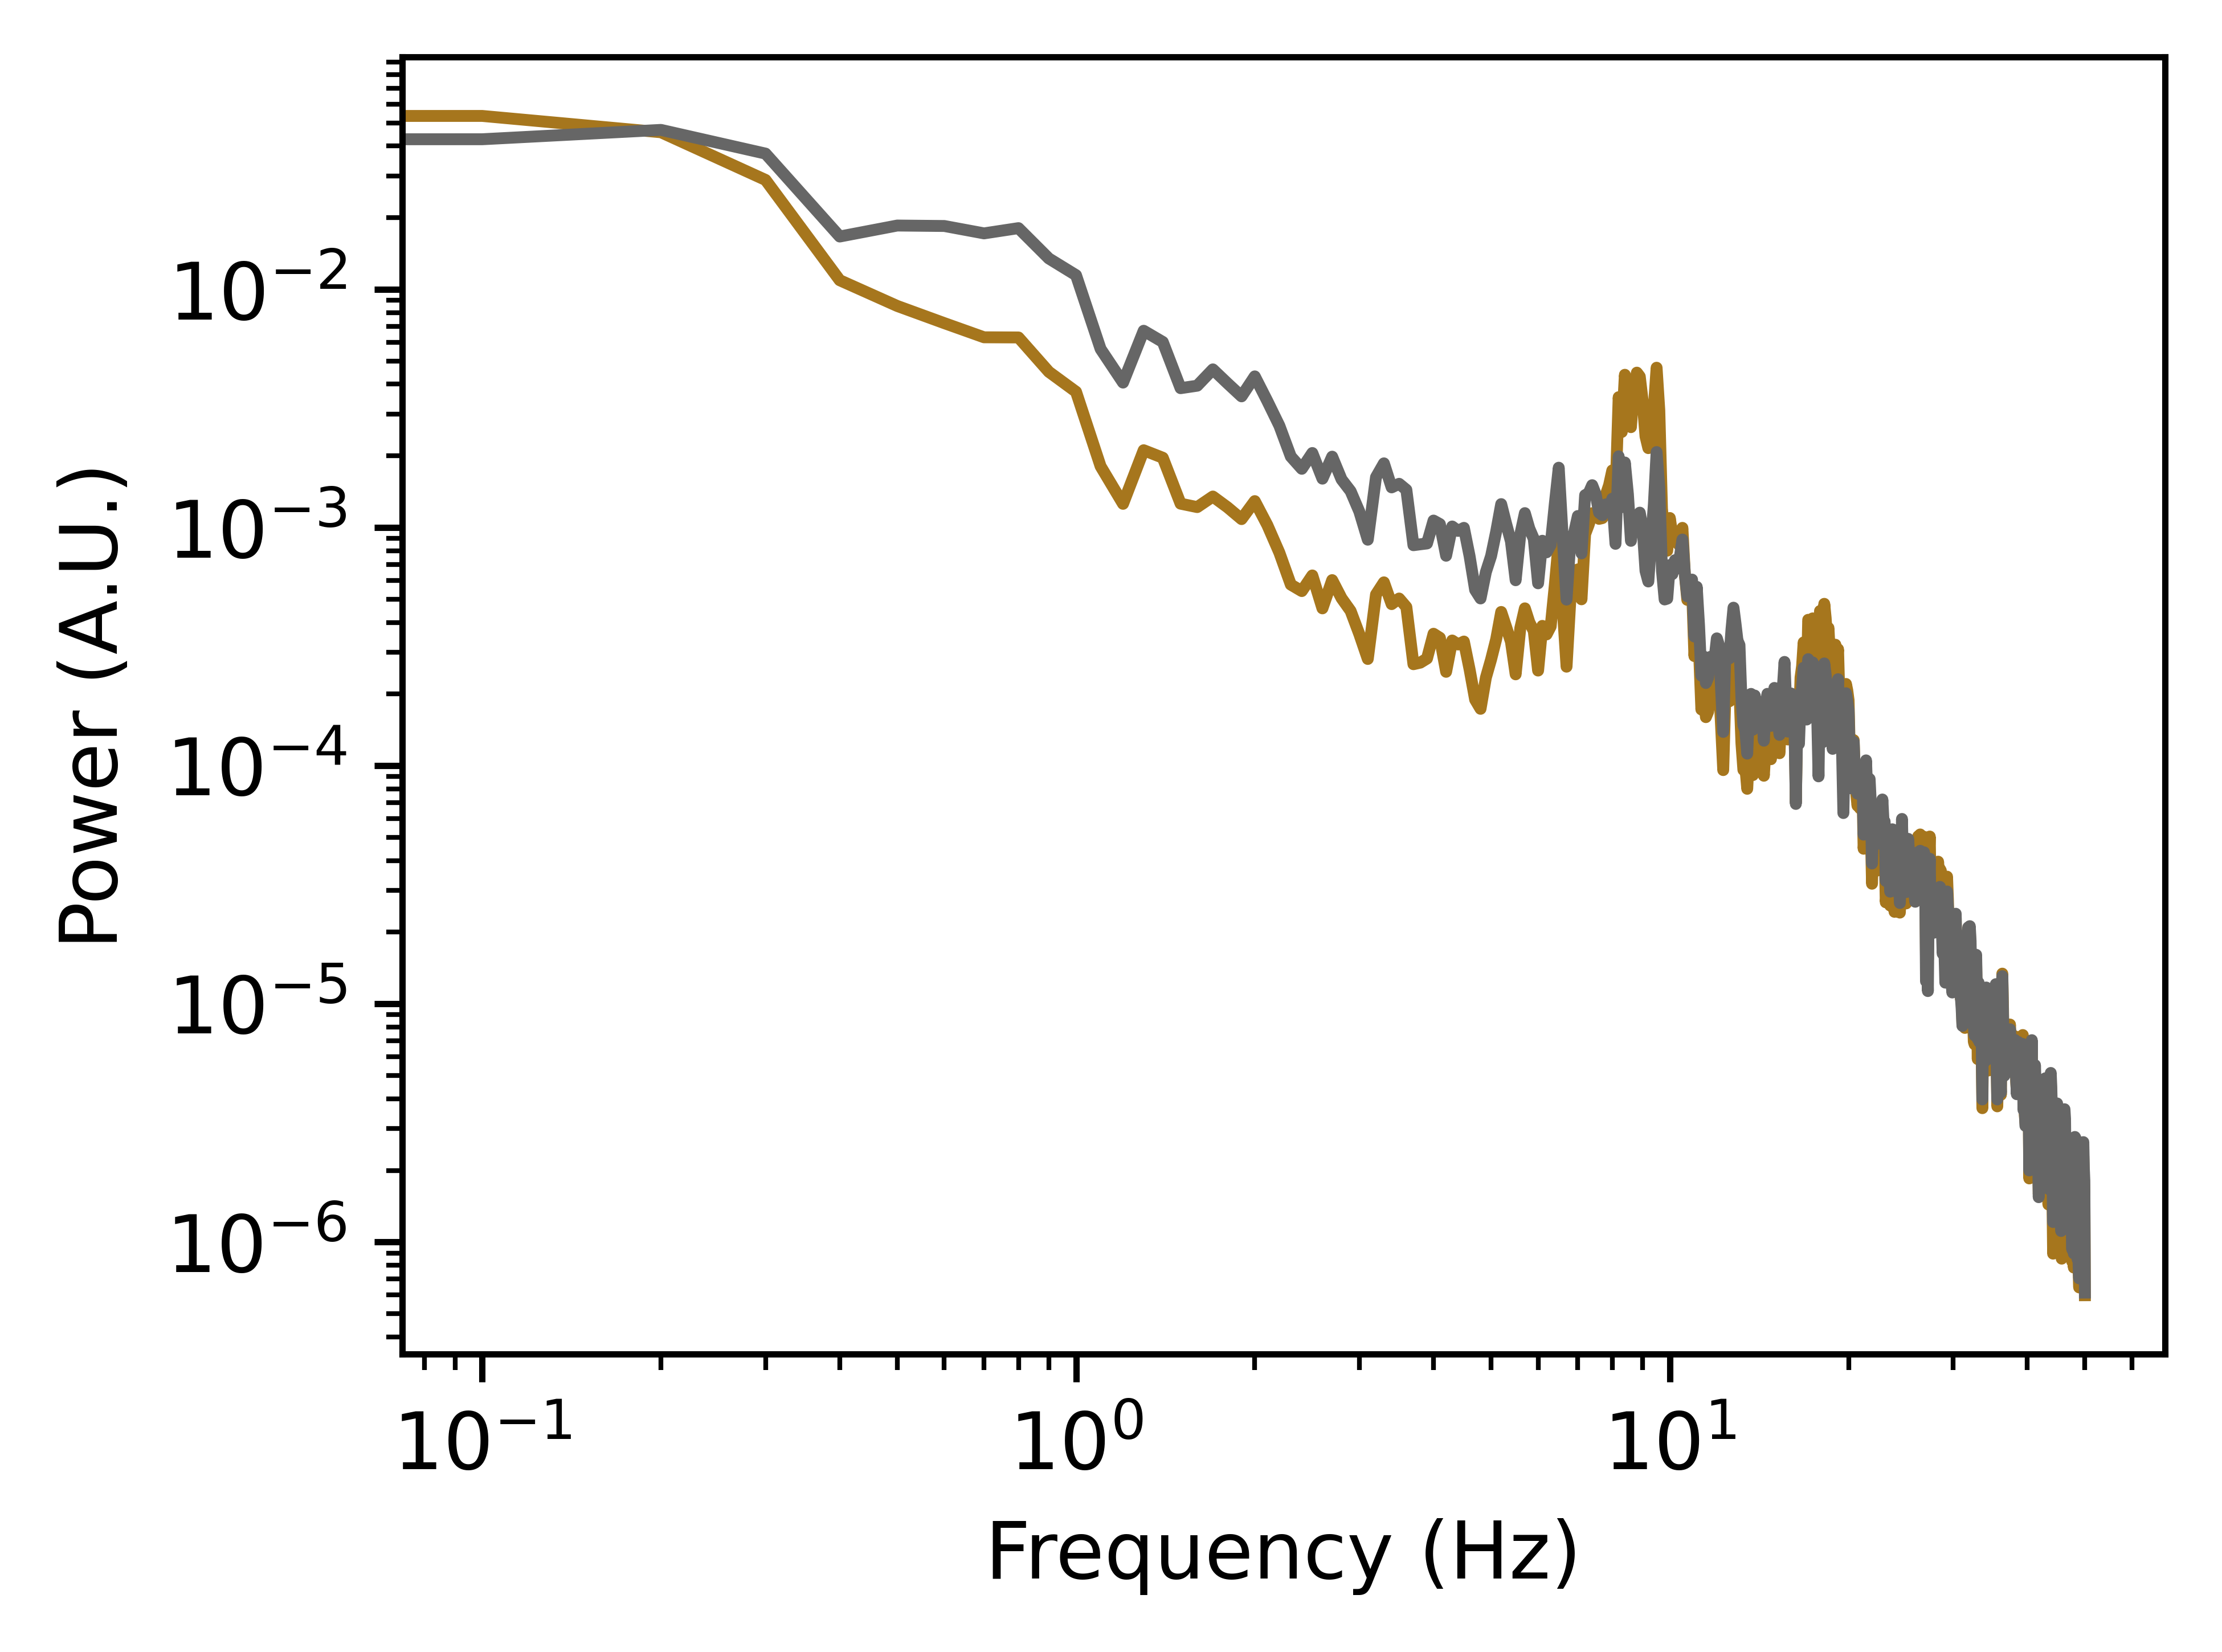

In [45]:
X_EC =signal.resample(phie_EYES_CLOSED,10000)
freqs_EC,ps_vPN_EC = welch(X_EC,fs=100, noverlap = 125, nperseg=1000)

X_EO=signal.resample(phie_EYES_OPEN,10000)
freqs_EO,ps_vPN_EO = welch(X_EO,fs=100, noverlap = 125, nperseg=1000)

plt.figure(figsize=(4, 3), dpi =1000)
plt.yscale("log")
plt.xscale("log")
plt.plot(freqs_EC,ps_vPN_EC, color= plt.cm.Dark2(6))
plt.plot(freqs_EO,ps_vPN_EO,color = plt.cm.Dark2(7))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (A.U.)')
plt.tight_layout()
plt.show()